In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import math
import torch
import random
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import MinMaxScaler


In [2]:
# -----------------------------
# 1) Load data + sort + remove 0s/missing + resampling
# -----------------------------
df = pd.read_csv("btcusd_1-min_data.csv")       # cols: Timestamp, Open, High, Low, Close, Volume

# Sort data by date
df['Timestamp'] = pd.to_datetime(df['Timestamp'], unit='s')

df = df.sort_values(by="Timestamp")

# Remove clearly bad rows
df = df[df["Close"] > 0]

# Set index to timestamp for resampling
df = df.set_index("Timestamp")


# Resample to DAILY candles

df_daily = df.resample('D').agg({
    'Open':   'first',
    'High':   'max',
    'Low':    'min',
    'Close':  'last',
    'Volume': 'sum'
})

# Drop days with missing values
df_daily = df_daily.dropna()


# using all 5 numerical columns - multi-feature improves prediction
feature_columns = ["Open", "High", "Low", "Close", "Volume"]
data = df_daily[feature_columns].copy()

print("Daily data shape:", data.shape)
print(data.head())


Daily data shape: (5086, 5)
            Open  High   Low  Close      Volume
Timestamp                                      
2012-01-01  4.58  4.84  4.58   4.84   10.000000
2012-01-02  4.84  5.00  4.84   5.00   10.100000
2012-01-03  5.00  5.32  5.00   5.29  107.085281
2012-01-04  5.29  5.57  4.93   5.57  107.233260
2012-01-05  5.57  6.46  5.57   6.42   70.328742


In [3]:
# -----------------------------
# 2) Data Split (07, 0.15, 0.15): time ordered & No Shuffle
# -----------------------------
n = len(data)
train_ratio = 0.70
val_ratio   = 0.15
test_ratio  = 0.15

train_end = int(n * train_ratio)
val_end   = int(n * (train_ratio + val_ratio))

train_data = data[:train_end]
val_data   = data[train_end:val_end]
test_data  = data[val_end:]

print(f"Train: {train_data.shape}, Val: {val_data.shape}, Test: {test_data.shape}")

# scaling 
scaler = MinMaxScaler()
scaler.fit(train_data)                 # Fit ONLY using train

train_scaled = scaler.transform(train_data)
val_scaled   = scaler.transform(val_data)
test_scaled  = scaler.transform(test_data)

# VERY IMPORTANT: convert to numpy float32 for PyTorch
train_scaled = train_scaled.astype(np.float32)
val_scaled   = val_scaled.astype(np.float32)
test_scaled  = test_scaled.astype(np.float32)

print(f"train_scaled.shape: {train_scaled.shape}")

Train: (3560, 5), Val: (763, 5), Test: (763, 5)
train_scaled.shape: (3560, 5)


In [4]:
# Conmfigs
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)


SEQ_LEN = 30       # last 30 days
PRED_LEN = 7       # predict next 7 days

FEATURES   = len(feature_columns)
BATCH_SIZE = 32

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [5]:
class SequenceDataset(Dataset):
    def __init__(self, series, seq_len, pred_len):
        self.seq_len = seq_len
        self.pred_len = pred_len
        self.X = []
        self.Y = []

        for i in range(len(series) - seq_len - pred_len):
            self.X.append(series[i : i + seq_len])
            self.Y.append(series[i + seq_len : i + seq_len + pred_len])

        self.X = np.array(self.X)
        self.Y = np.array(self.Y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        # return np.array(X), np.array(Y)  
        
        return (
            torch.tensor(self.X[idx], dtype=torch.float32),
            torch.tensor(self.Y[idx], dtype=torch.float32),
        )


In [6]:
# generates data seqs
train_ds = SequenceDataset(train_scaled, SEQ_LEN, PRED_LEN)
val_ds   = SequenceDataset(val_scaled,   SEQ_LEN, PRED_LEN)
test_ds  = SequenceDataset(test_scaled,  SEQ_LEN, PRED_LEN)

# create dataloaders
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_ds,  batch_size=1, shuffle=False)

In [7]:
print("\n=== SHAPE CHECK ===")
print("train_scaled:", train_scaled.shape)
print("val_scaled:",   val_scaled.shape)
print("test_scaled:",  test_scaled.shape)


print("\n=== DATASET WINDOW SHAPES ===")
print("train_ds X shape:", train_ds.X.shape)
print("train_ds Y shape:", train_ds.Y.shape)
print("val_ds   X shape:", val_ds.X.shape)
print("val_ds   Y shape:", val_ds.Y.shape)
print("test_ds  X shape:", test_ds.X.shape)
print("test_ds  Y shape:", test_ds.Y.shape)


batch = next(iter(train_loader))
xb, yb = batch
print("\n=== FIRST BATCH ===")
print("xb:", xb.shape)
print("yb:", yb.shape)


print("\n=== SAMPLE CONTENT ===")
print("X[0]:\n", train_ds.X[1000][:10])     # first 10 time steps in 1000th window
print("Y[0]:\n", train_ds.Y[1000][:3])     # first few predicted points


print("\n=== LAST VALUE TRAIN / FIRST VALUE VAL ===")
print(train_scaled[-1])
print(val_scaled[0])


assert len(train_scaled) + len(val_scaled) + len(test_scaled) == len(data)
print("No leak or overlap across splits ✔️")


i = 100
print("\n=== ALIGNMENT CHECK ===")
print("X window ends at: ", train_scaled[i + SEQ_LEN - 1])
print("Y window starts at:", train_scaled[i + SEQ_LEN])


num_features = train_ds.X.shape[-1]
assert train_ds.X.shape[-1] == num_features
print("Correct feature dimensionality ✔️")



=== SHAPE CHECK ===
train_scaled: (3560, 5)
val_scaled: (763, 5)
test_scaled: (763, 5)

=== DATASET WINDOW SHAPES ===
train_ds X shape: (3523, 30, 5)
train_ds Y shape: (3523, 7, 5)
val_ds   X shape: (726, 30, 5)
val_ds   Y shape: (726, 7, 5)
test_ds  X shape: (726, 30, 5)
test_ds  Y shape: (726, 7, 5)

=== FIRST BATCH ===
xb: torch.Size([32, 30, 5])
yb: torch.Size([32, 7, 5])

=== SAMPLE CONTENT ===
X[0]:
 [[0.00632599 0.00624279 0.0063572  0.0062471  0.04519231]
 [0.00624454 0.00615819 0.00602689 0.00594942 0.08991647]
 [0.00593892 0.00588142 0.00584322 0.00583785 0.16224073]
 [0.00586535 0.00600116 0.00585615 0.00611851 0.12574907]
 [0.00611946 0.00606203 0.00603416 0.00600001 0.11715646]
 [0.00599816 0.0058882  0.00596933 0.00587677 0.07430361]
 [0.00587544 0.00576969 0.00571064 0.00563409 0.13809684]
 [0.00563173 0.00555841 0.00520408 0.00509986 0.21146797]
 [0.00509012 0.00516329 0.00438484 0.00499948 0.43840787]
 [0.00494078 0.00527994 0.00472259 0.00513532 0.62624174]]
Y[0]:
 [

X shape: torch.Size([30, 5])
Y shape: torch.Size([7, 5])

First few X values:
tensor([[7.4042e-06, 7.5511e-06, 1.5360e-05, 6.6187e-06, 3.2589e-03],
        [6.6165e-06, 7.7052e-06, 1.5845e-05, 7.8794e-06, 2.0590e-03],
        [7.8768e-06, 8.3217e-06, 1.5036e-05, 7.5642e-06, 5.4461e-03],
        [7.5617e-06, 8.7840e-06, 1.6330e-05, 8.0370e-06, 7.9415e-03],
        [8.0343e-06, 9.7086e-06, 1.7138e-05, 9.4553e-06, 5.8187e-03]])

First few Y values:
tensor([[1.0397e-05, 1.0171e-05, 1.7785e-05, 9.9280e-06, 7.1783e-03],
        [9.9247e-06, 9.7086e-06, 1.7300e-05, 8.6673e-06, 3.5581e-03],
        [8.6644e-06, 9.0922e-06, 1.8270e-05, 9.2977e-06, 8.1015e-04],
        [9.2946e-06, 9.0922e-06, 1.7947e-05, 8.8249e-06, 4.5987e-03],
        [8.8220e-06, 9.4004e-06, 1.7462e-05, 9.6129e-06, 5.5523e-03]])


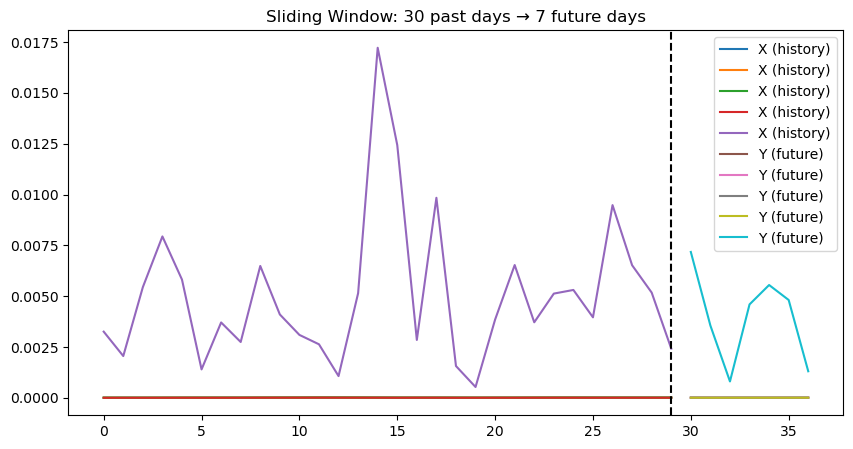

X variance: 6.5168824e-06
Y variance: 3.4027746e-06


In [8]:
# pick any window index you want
idx = 100

x_sample, y_sample = train_ds[idx]

print("X shape:", x_sample.shape)  # (30, 1)
print("Y shape:", y_sample.shape)  # (7, 1)

print("\nFirst few X values:")
print(x_sample[:5])

print("\nFirst few Y values:")
print(y_sample[:5])



x_plot = x_sample.squeeze().numpy()
y_plot = y_sample.squeeze().numpy()

plt.figure(figsize=(10,5))

plt.plot(range(len(x_plot)), x_plot, label="X (history)")
plt.plot(range(len(x_plot), len(x_plot)+len(y_plot)), y_plot, label="Y (future)")

plt.axvline(len(x_plot)-1, color='black', linestyle='--')  # boundary marker

plt.title("Sliding Window: 30 past days → 7 future days")
plt.legend()
plt.show()

print("X variance:", x_plot.var())
print("Y variance:", y_plot.var())


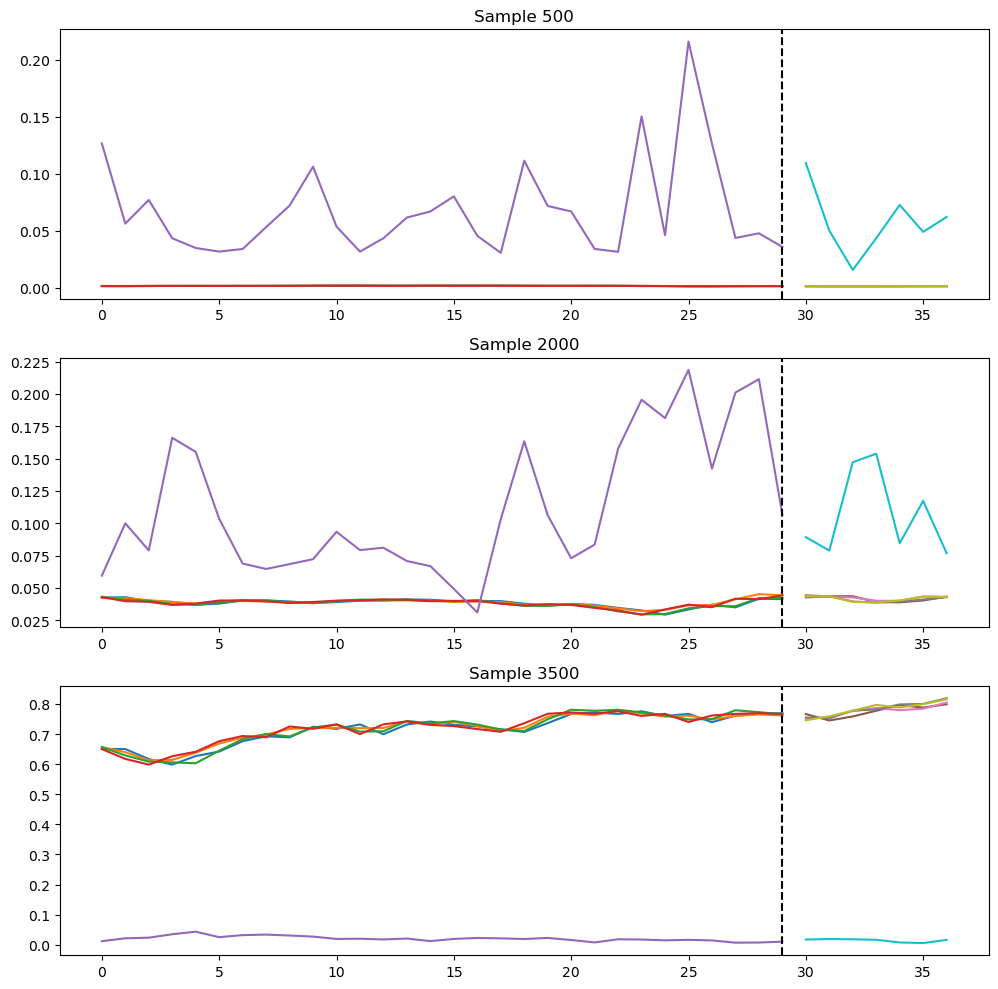

In [9]:
fig, axes = plt.subplots(3, 1, figsize=(10, 10))

for i, ax in enumerate(axes):
    x_sample, y_sample = train_ds[500 + i*1500]
    x_plot = x_sample.squeeze().numpy()
    y_plot = y_sample.squeeze().numpy()
    
    ax.plot(range(len(x_plot)), x_plot, label="X")
    ax.plot(range(len(x_plot), len(x_plot)+len(y_plot)), y_plot, label="Y")
    ax.axvline(len(x_plot)-1, color='black', linestyle='--')
    ax.set_title(f"Sample {500 + i*1500}")

plt.tight_layout()
plt.show()


In [10]:
batch = next(iter(train_loader))
xb, yb = batch   # xb: (B, 30, 1), yb: (B, 7, 1)

print("input:", xb.shape)   # sanity
print("target:", yb.shape)


input: torch.Size([32, 30, 5])
target: torch.Size([32, 7, 5])


In [11]:
class BaselineLSTM(nn.Module):
    """
    Baseline multi-step forecasting model using a single LSTM encoder.
    
    - Input:  (batch_size, sequence_length, number_of_features)
              Example: (32, 30, 1)
    
    - Output: (batch_size, prediction_length, number_of_features)
              Example: (32, 7, 1)
    
    How it works:
    1) LSTM encodes the entire historical window (30 timesteps)
    2) We extract the final hidden state as a sequence summary
    3) A fully-connected layer converts this hidden representation
       directly into all future predictions at once
    """

    def __init__(self, number_of_input_features, hidden_dimension, prediction_length):
        super().__init__()

        # The LSTM encoder reads temporal patterns from the input sequence
        self.lstm_encoder = nn.LSTM(
            input_size = number_of_input_features,
            hidden_size = hidden_dimension,
            batch_first = True
        )

        # Fully-connected layer converts the hidden representation
        # into "prediction_length × number_of_input_features" outputs
        self.fully_connected_layer = nn.Linear(
            hidden_dimension,
            prediction_length * number_of_input_features
        )

        self.prediction_length       = prediction_length
        self.number_of_input_features = number_of_input_features

    def forward(self, input_sequence):
        """
        input_sequence shape: (batch_size, sequence_length, number_of_features)
        """

        # Run LSTM encoder and extract final hidden state
        _, (last_hidden_state, _) = self.lstm_encoder(input_sequence)

        # Remove layer dimension: (1, batch_size, hidden_dim) → (batch_size, hidden_dim)
        last_hidden_state = last_hidden_state.squeeze(0)

        # Fully-connected layer predicts all future timesteps at once
        prediction_vector = self.fully_connected_layer(last_hidden_state)

        # Reshape output into 3D forecast: (batch_size, prediction_length, number_of_features)
        forecast = prediction_vector.view(
            input_sequence.size(0),
            self.prediction_length,
            self.number_of_input_features
        )

        return forecast


In [12]:
class Seq2SeqLSTM(nn.Module):
    """
    Encoder–Decoder LSTM for multi-step forecasting.

    - Encoder reads the entire historical window
      and outputs a hidden representation of the sequence

    - Decoder produces future values one at a time (autoregressive),
      where each predicted timestep becomes input for the next step

    - Teacher forcing stabilizes training by occasionally replacing
      the previous prediction with the real value from ground truth
    """

    def __init__(self, number_of_input_features, hidden_dimension, prediction_length):
        super().__init__()

        # Encoder: compresses the input temporal window into latent state
        self.encoder_lstm = nn.LSTM(
            input_size  = number_of_input_features,
            hidden_size = hidden_dimension,
            batch_first = True
        )

        # Decoder: autoregressive forecasting of each timestep
        self.decoder_lstm = nn.LSTM(
            input_size  = number_of_input_features,
            hidden_size = hidden_dimension,
            batch_first = True
        )

        # Fully-connected layer to convert decoder output
        # into actual forecasted value for each timestep
        self.fully_connected_layer = nn.Linear(
            hidden_dimension,
            number_of_input_features
        )

        self.prediction_length        = prediction_length
        self.number_of_input_features = number_of_input_features
        self.hidden_dimension         = hidden_dimension

    def forward(self, input_sequence, target_sequence=None, use_teacher_forcing=False):
        """
        input_sequence: (batch_size, sequence_length, number_of_features)
        target_sequence: (batch_size, prediction_length, number_of_features)
        """

        # 1) Encode historical window
        _, (hidden_state, cell_state) = self.encoder_lstm(input_sequence)

        # 2) Initialize decoder input using last known timestep
        decoder_input = input_sequence[:, -1:, :]   # (batch_size, 1, number_of_features)

        forecast_outputs = []

        # 3) Autoregressive decoding loop
        for timestep in range(self.prediction_length):

            # Run decoder for a single timestep
            decoding_output, (hidden_state, cell_state) = self.decoder_lstm(
                decoder_input,
                (hidden_state, cell_state)
            )

            # Convert decoder output → forecast value for this timestep
            prediction = self.fully_connected_layer(decoding_output)

            forecast_outputs.append(prediction)

            # Determine next decoder input
            if use_teacher_forcing and target_sequence is not None:
                decoder_input = target_sequence[:, timestep:timestep+1, :]
            else:
                decoder_input = prediction

        # Combine list of predictions into one tensor:
        # (batch_size, prediction_length, number_of_features)
        forecast = torch.cat(forecast_outputs, dim=1)

        return forecast


In [13]:

class PositionalEncoding(nn.Module):
    """
    Standard sinusoidal positional encoding.
    
    - Adds a deterministic temporal signal to each embedding
    - Provides explicit information about timestep index
    - Helps transformer reason about ordering and lag
    """
    def __init__(self, embedding_dimension, maximum_sequence_length = 5000):
        super().__init__()

        # Create matrix for all positions and all embedding dims
        positional_encoding_matrix = torch.zeros(maximum_sequence_length, embedding_dimension)

        # Position index: 0,1,2,... up to maximum_sequence_length
        position_index_vector = torch.arange(0, maximum_sequence_length, dtype=torch.float).unsqueeze(1)

        # Denominator term for sin/cos wave frequencies
        denominator_term = torch.exp(
            torch.arange(0, embedding_dimension, 2).float() *
            (-math.log(10000.0) / embedding_dimension)
        )

        # Even dimensions: sine
        positional_encoding_matrix[:, 0::2] = torch.sin(position_index_vector * denominator_term)

        # Odd dimensions: cosine
        positional_encoding_matrix[:, 1::2] = torch.cos(position_index_vector * denominator_term)

        # Register buffer = persistent, non-trainable, moved automatically to CUDA/CPU
        self.register_buffer("positional_encoding_matrix", positional_encoding_matrix.unsqueeze(1))
        # shape: (max_len, 1, embedding_dimension)

    def forward(self, embedding_sequence):
        """
        embedding_sequence shape: (sequence_length, batch_size, embedding_dimension)
        """
        sequence_length = embedding_sequence.size(0)

        # Add positional encoding to embedding
        return embedding_sequence + self.positional_encoding_matrix[:sequence_length, :]


In [14]:
class TransformerWithPositionalEncoding(nn.Module):
    """
    Transformer forecaster WITH explicit positional encoding.
    
    Differences from previous TransformerPredictor:
    - After projecting input features into embeddings
      we add sinusoidal positional encoding
    """

    def __init__(self,
                 number_of_input_features,
                 prediction_length,
                 transformer_embedding_dimension = 64,
                 number_of_attention_heads       = 4,
                 number_of_encoder_layers        = 2):
        super().__init__()

        # 1) Project original feature dimensions (OHLCV) → transformer embedding
        self.input_projection_layer = nn.Linear(
            number_of_input_features,
            transformer_embedding_dimension
        )

        # 2) Sinusoidal positional encoding module
        self.positional_encoding = PositionalEncoding(
            embedding_dimension = transformer_embedding_dimension,
            maximum_sequence_length = 5000
        )

        # 3) Transformer encoder stack
        encoder_layer = nn.TransformerEncoderLayer(
            d_model     = transformer_embedding_dimension,
            nhead       = number_of_attention_heads,
            batch_first = False
        )

        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer,
            num_layers = number_of_encoder_layers
        )

        # 4) Fully connected layer for forecasting
        self.fully_connected_layer = nn.Linear(
            transformer_embedding_dimension,
            prediction_length * number_of_input_features
        )

        self.prediction_length        = prediction_length
        self.number_of_input_features = number_of_input_features

    def forward(self, input_sequence):
        """
        input_sequence shape: (batch, sequence_length, number_of_features)
        """

        # Step A: project into embedding space
        embedded_sequence = self.input_projection_layer(input_sequence)
        # shape: (batch, seq_len, embedding_dim)

        # Step B: convert to (seq_len, batch, embedding_dim)
        embedded_sequence = embedded_sequence.permute(1, 0, 2)

        # Step C: add positional encoding (explicit ordering info)
        embedded_sequence = self.positional_encoding(embedded_sequence)

        # Step D: transformer encoder learns temporal + cross-feature dependencies
        encoded_sequence = self.transformer_encoder(embedded_sequence)

        # Step E: final timestep embedding represents entire window
        final_embedding = encoded_sequence[-1]   # shape: (batch, embedding_dim)

        # Step F: map to multi-step, multi-feature forecast
        prediction_vector = self.fully_connected_layer(final_embedding)
        # shape: (batch, pred_len * features)

        # Step G: reshape into 3D output (consistent across models)
        forecast = prediction_vector.view(
            encoded_sequence.size(1),             # batch size
            self.prediction_length,
            self.number_of_input_features
        )

        return forecast


In [15]:
# Hyperparameters

hidden_dimension = 64
learning_rate    = 3e-4
number_of_epochs = 30

baseline_model = BaselineLSTM(
    number_of_input_features = FEATURES,
    hidden_dimension         = hidden_dimension,
    prediction_length        = PRED_LEN
)

seq2seq_model = Seq2SeqLSTM(
    number_of_input_features = FEATURES,
    hidden_dimension         = hidden_dimension,
    prediction_length        = PRED_LEN
)

transformer_posenc_model = TransformerWithPositionalEncoding(
    number_of_input_features        = FEATURES,
    prediction_length               = PRED_LEN,
    transformer_embedding_dimension = 64,
    number_of_attention_heads       = 4,
    number_of_encoder_layers        = 2
)

C:\Users\clear\anaconda3\envs\my_env\Lib\site-packages\torch\nn\modules\transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [16]:
def run_one_epoch(
    model,
    data_loader,
    loss_function,
    optimizer,
    device,
    is_training,
    is_seq2seq_model = False,
    use_teacher_forcing = False
):
    """
    Runs one epoch of training or validation over the entire data_loader.
    
    Parameters:
    - model: the forecasting model (BaselineLSTM, Seq2SeqLSTM, TransformerPredictor)
    - data_loader: DataLoader for train or validation data
    - loss_function: for example, nn.MSELoss()
    - optimizer: Adam optimizer (used only when is_training = True)
    - device: 'cpu' or 'cuda'
    - is_training: True for training, False for evaluation
    - is_seq2seq_model: True only for Seq2SeqLSTM
    - use_teacher_forcing: used only during training for Seq2SeqLSTM
    """
    
    if is_training:
        model.train()
    else:
        model.eval()
    
    total_loss_value = 0.0
    number_of_batches = 0
    
    # We do not want gradients during evaluation
    context_manager = torch.enable_grad if is_training else torch.no_grad
    
    with context_manager():
        for batch in data_loader:
            input_sequence, target_sequence = batch  # shapes: (B, seq_len, 1), (B, pred_len, 1)
            
            input_sequence  = input_sequence.to(device)
            target_sequence = target_sequence.to(device)
            
            if is_training:
                optimizer.zero_grad()
            
            # Forward pass (different for seq2seq vs others)
            if is_seq2seq_model:
                # Seq2Seq model expects target_sequence if we use teacher forcing during training
                model_output = model(
                    input_sequence,
                    target_sequence = target_sequence if use_teacher_forcing else None,
                    use_teacher_forcing = use_teacher_forcing
                )
            else:
                # Baseline LSTM or Transformer do not need target_sequence in forward
                model_output = model(input_sequence)
            
            # model_output and target_sequence should both be (B, PRED_LEN, FEATURES)
            loss_value = loss_function(model_output, target_sequence)
            
            if is_training:
                loss_value.backward()
                optimizer.step()
            
            batch_loss_scalar = loss_value.item()
            total_loss_value += batch_loss_scalar
            number_of_batches += 1
    
    average_loss_value = total_loss_value / max(1, number_of_batches)
    return average_loss_value


In [17]:
def train_model(
    model,
    train_loader,
    validation_loader,
    number_of_epochs,
    learning_rate,
    device,
    is_seq2seq_model = False,
    teacher_forcing_enabled = True,
    early_stopping_patience = 5
):
    """
    Trains any of the three models with a unified loop.
    
    Parameters:
    - model: one of BaselineLSTM, Seq2SeqLSTM, TransformerPredictor
    - train_loader, validation_loader: DataLoaders
    - number_of_epochs: for example 20 or 50
    - learning_rate: for example 1e-3
    - is_seq2seq_model: True only when model is Seq2SeqLSTM
    - teacher_forcing_enabled: whether to use teacher forcing for Seq2Seq during training
    - early_stopping_patience: stop if validation does not improve for N epochs
    """
    
    model.to(device)
    
    loss_function = nn.MSELoss()
    optimizer_for_model = torch.optim.Adam(model.parameters(), lr = learning_rate)
    
    training_loss_history    = []
    validation_loss_history  = []
    
    best_validation_loss_value = float("inf")
    epochs_without_improvement = 0
    
    for epoch_index in range(1, number_of_epochs + 1):
        # --- Training phase ---
        training_loss_value = run_one_epoch(
            model               = model,
            data_loader         = train_loader,
            loss_function       = loss_function,
            optimizer           = optimizer_for_model,
            device              = device,
            is_training         = True,
            is_seq2seq_model    = is_seq2seq_model,
            use_teacher_forcing = (teacher_forcing_enabled and is_seq2seq_model)
        )
        
        # --- Validation phase (no teacher forcing) ---
        validation_loss_value = run_one_epoch(
            model               = model,
            data_loader         = validation_loader,
            loss_function       = loss_function,
            optimizer           = optimizer_for_model,
            device              = device,
            is_training         = False,
            is_seq2seq_model    = is_seq2seq_model,
            use_teacher_forcing = False
        )
        
        training_loss_history.append(training_loss_value)
        validation_loss_history.append(validation_loss_value)
        
        print(
            f"Epoch {epoch_index:03d} | "
            f"Train Loss: {training_loss_value:.6f} | "
            f"Val Loss: {validation_loss_value:.6f}"
        )
        
        # --- Early stopping check ---
        if validation_loss_value < best_validation_loss_value - 1e-6:
            best_validation_loss_value = validation_loss_value
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
        
        if epochs_without_improvement >= early_stopping_patience:
            print(f"Stopping early at epoch {epoch_index} "
                  f"due to no improvement in validation loss.")
            break
    
    return model, training_loss_history, validation_loss_history


In [18]:

baseline_model, baseline_train_loss, baseline_val_loss = train_model(
    model                  = baseline_model,
    train_loader           = train_loader,
    validation_loader      = val_loader,
    number_of_epochs       = number_of_epochs,
    learning_rate          = learning_rate,
    device                 = device,
    is_seq2seq_model       = False,      # baseline is NOT seq2seq
    teacher_forcing_enabled= False       # no teacher forcing to worry about
)



seq2seq_model, seq2seq_train_loss, seq2seq_val_loss = train_model(
    model                  = seq2seq_model,
    train_loader           = train_loader,
    validation_loader      = val_loader,
    number_of_epochs       = number_of_epochs,
    learning_rate          = learning_rate,
    device                 = device,
    is_seq2seq_model       = True,       # IMPORTANT: this enables seq2seq behavior
    teacher_forcing_enabled= True        # enable teacher forcing during training
)



transformer_posenc_model, transformer_train_loss, transformer_val_loss = train_model(
    model                  = transformer_posenc_model,
    train_loader           = train_loader,
    validation_loader      = val_loader,
    number_of_epochs       = number_of_epochs,
    learning_rate          = learning_rate,
    device                 = device,
    is_seq2seq_model       = False,      # transformer is NOT seq2seq
    teacher_forcing_enabled= False
)


Epoch 001 | Train Loss: 0.026020 | Val Loss: 0.007711
Epoch 002 | Train Loss: 0.002869 | Val Loss: 0.011516
Epoch 003 | Train Loss: 0.001843 | Val Loss: 0.003384
Epoch 004 | Train Loss: 0.001675 | Val Loss: 0.001984
Epoch 005 | Train Loss: 0.001589 | Val Loss: 0.001957
Epoch 006 | Train Loss: 0.001520 | Val Loss: 0.003105
Epoch 007 | Train Loss: 0.001492 | Val Loss: 0.001655
Epoch 008 | Train Loss: 0.001396 | Val Loss: 0.001575
Epoch 009 | Train Loss: 0.001365 | Val Loss: 0.001512
Epoch 010 | Train Loss: 0.001323 | Val Loss: 0.002334
Epoch 011 | Train Loss: 0.001272 | Val Loss: 0.001366
Epoch 012 | Train Loss: 0.001299 | Val Loss: 0.001311
Epoch 013 | Train Loss: 0.001224 | Val Loss: 0.001387
Epoch 014 | Train Loss: 0.001202 | Val Loss: 0.001168
Epoch 015 | Train Loss: 0.001201 | Val Loss: 0.001281
Epoch 016 | Train Loss: 0.001183 | Val Loss: 0.001588
Epoch 017 | Train Loss: 0.001191 | Val Loss: 0.001121
Epoch 018 | Train Loss: 0.001182 | Val Loss: 0.001099
Epoch 019 | Train Loss: 0.00

C:\Users\clear\anaconda3\envs\my_env\Lib\site-packages\torch\nn\functional.py:5476: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)


Epoch 001 | Train Loss: 0.026431 | Val Loss: 0.005760
Epoch 002 | Train Loss: 0.006314 | Val Loss: 0.002781
Epoch 003 | Train Loss: 0.004111 | Val Loss: 0.002338
Epoch 004 | Train Loss: 0.003125 | Val Loss: 0.002066
Epoch 005 | Train Loss: 0.002650 | Val Loss: 0.002343
Epoch 006 | Train Loss: 0.002295 | Val Loss: 0.001865
Epoch 007 | Train Loss: 0.002019 | Val Loss: 0.001033
Epoch 008 | Train Loss: 0.001926 | Val Loss: 0.001804
Epoch 009 | Train Loss: 0.001857 | Val Loss: 0.001811
Epoch 010 | Train Loss: 0.001694 | Val Loss: 0.001580
Epoch 011 | Train Loss: 0.001610 | Val Loss: 0.001181
Epoch 012 | Train Loss: 0.001542 | Val Loss: 0.001385
Stopping early at epoch 12 due to no improvement in validation loss.


In [19]:
# Test Evaluation Function
def evaluate_on_test_set(
    model,
    test_loader,
    device,
    is_seq2seq_model = False
):
    """
    Evaluates a forecasting model over the entire test set.
    
    Returns:
    - mean MSE
    - mean MAE
    """

    model.to(device)
    model.eval()

    mean_squared_error_list = []
    mean_absolute_error_list = []

    loss_mse = nn.MSELoss(reduction="none")
    loss_mae = nn.L1Loss(reduction="none")

    with torch.no_grad():
        for batch in test_loader:
            input_sequence, target_sequence = batch
            input_sequence  = input_sequence.to(device)
            target_sequence = target_sequence.to(device)

            if is_seq2seq_model:
                prediction = model(input_sequence, use_teacher_forcing=False)
            else:
                prediction = model(input_sequence)

            # prediction and target_sequence: (B, 7, 1)
            batch_mse = loss_mse(prediction, target_sequence).mean().item()
            batch_mae = loss_mae(prediction, target_sequence).mean().item()

            mean_squared_error_list.append(batch_mse)
            mean_absolute_error_list.append(batch_mae)

    final_mse = np.mean(mean_squared_error_list)
    final_mae = np.mean(mean_absolute_error_list)

    return final_mse, final_mae


In [20]:
def inverse_scale_sequence(scaled_sequence, scaler):
    """
    scaled_sequence: shape (pred_len,) or (pred_len, 1)
    we always reshape to 2D for scaler
    """
    scaled_sequence = scaled_sequence.reshape(-1, FEATURES)
    return scaler.inverse_transform(scaled_sequence)


In [21]:
# plot function
def plot_test_forecast(
    model,
    test_dataset,
    scaler,
    device,
    sample_index = None,
    is_seq2seq_model = False
):
    """
    Visualizes forecast vs actual for one test sample.
    """

    model.to(device)
    model.eval()

    # pick a random test index if not given
    if sample_index is None:
        sample_index = np.random.randint(0, len(test_dataset))

    input_sequence, target_sequence = test_dataset[sample_index]
    input_sequence  = input_sequence.to(device).unsqueeze(0)  # add batch dim
    target_sequence = target_sequence.unsqueeze(0)            # shape (1, 7, 1)

    with torch.no_grad():
        if is_seq2seq_model:
            prediction = model(input_sequence, use_teacher_forcing=False)
        else:
            prediction = model(input_sequence)

    # convert to numpy
    predicted_scaled = prediction.squeeze().cpu().numpy()        # (7, 1)
    actual_scaled    = target_sequence.squeeze().cpu().numpy()    # (7, 1)

    # inverse transform
    predicted_actual = inverse_scale_sequence(predicted_scaled, scaler)
    future_actual    = inverse_scale_sequence(actual_scaled, scaler)

    predicted_close = predicted_actual[:, feature_columns.index("Close")]
    true_close      = future_actual[:, feature_columns.index("Close")]


    # --- plotting ---
    plt.figure(figsize=(9, 4))
    plt.plot(true_close, label="True Future", marker='o')
    plt.plot(predicted_close, label="Predicted Future", marker='x')
    
    plt.title("7-Day Forecast (Test Sample)")
    plt.xlabel("Future Day Index")
    plt.ylabel("BTC Price")
    plt.legend()
    plt.grid(True)
    plt.show()


Baseline Test MSE: 0.04005382031180028
Baseline Test MAE: 0.14785029924379728


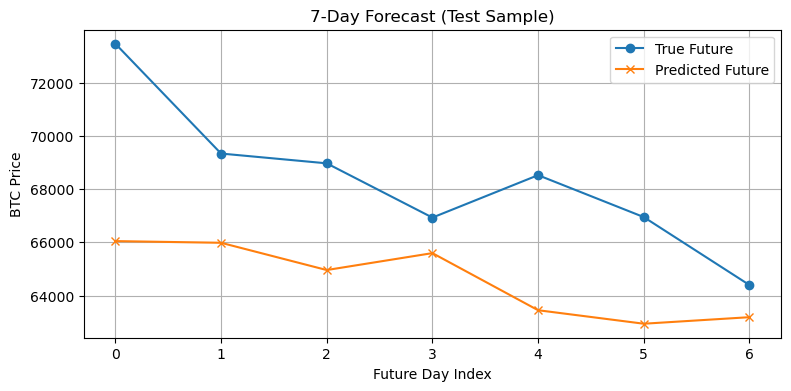

In [22]:
baseline_test_mse, baseline_test_mae = evaluate_on_test_set(
    model      = baseline_model,
    test_loader= test_loader,
    device     = device,
    is_seq2seq_model = False
)

print("Baseline Test MSE:", baseline_test_mse)
print("Baseline Test MAE:", baseline_test_mae)

plot_test_forecast(
    model        = baseline_model,
    test_dataset = test_ds,
    scaler       = scaler,
    device       = device,
    is_seq2seq_model = False
)


Seq2Seq Test MSE: 0.03315797277700416
Seq2Seq Test MAE: 0.12563646858501615


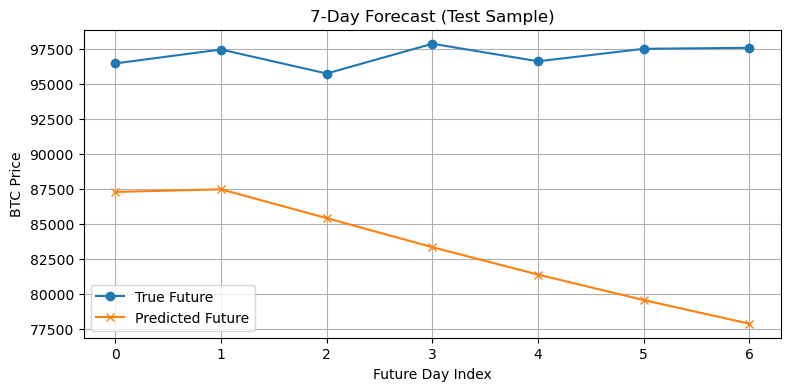

In [23]:
seq2seq_test_mse, seq2seq_test_mae = evaluate_on_test_set(
    model      = seq2seq_model,
    test_loader= test_loader,
    device     = device,
    is_seq2seq_model = True
)

print("Seq2Seq Test MSE:", seq2seq_test_mse)
print("Seq2Seq Test MAE:", seq2seq_test_mae)

plot_test_forecast(
    model        = seq2seq_model,
    test_dataset = test_ds,
    scaler       = scaler,
    device       = device,
    is_seq2seq_model = True
)


Transformer Test MSE: 0.1478680534546734
Transformer Test MAE: 0.26551518388882733


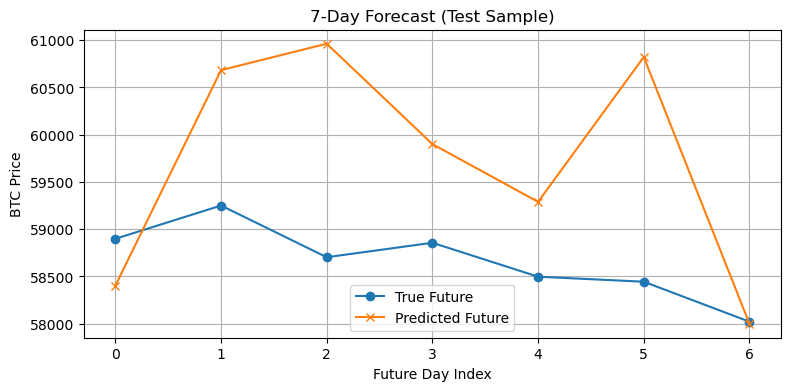

In [24]:
transformer_test_mse, transformer_test_mae = evaluate_on_test_set(
    model      = transformer_posenc_model,
    test_loader= test_loader,
    device     = device,
    is_seq2seq_model = False
)

print("Transformer Test MSE:", transformer_test_mse)
print("Transformer Test MAE:", transformer_test_mae)

plot_test_forecast(
    model        = transformer_posenc_model,
    test_dataset = test_ds,
    scaler       = scaler,
    device       = device,
    is_seq2seq_model = False
)
